In [75]:
# Dependencies
import json
import csv
import os
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import requests
import time
import datetime
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import linregress
import requests
import hvplot.pandas
from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf

Research Question:

Predict value of used cars based on factors such as: make and model and year of make of the car, number of accidents, number of owners and mileage.

Data: 

The dataset can be found and dowloaded from the following link https://www.kaggle.com/code/pandu0/car-resale-price-prediction-scikit-learn/input

In [76]:
# Store filepath in a variable
file_path = "Resources/car_web_scraped_dataset.csv"

In [77]:
# Read our Data file with the pandas library
usedcars_df = pd.read_csv(file_path, encoding="ISO-8859-1")

In [78]:
usedcars_df.head()

,name,year,miles,color,condition,price
0,Kia Forte,2022,"41,406 miles","Gray exterior, Black interior","No accidents reported, 1 Owner","$15,988"
1,Chevrolet Silverado 1500,2021,"15,138 miles","White exterior, Black interior","1 accident reported, 1 Owner","$38,008"
2,Toyota RAV4,2022,"32,879 miles","Silver exterior, Unknown interior","No accidents reported, 1 Owner","$24,988"
3,Honda Civic,2020,"37,190 miles","Blue exterior, Black interior","No accidents reported, 1 Owner","$18,998"
4,Honda Civic,2020,"27,496 miles","Black exterior, Black interior","No accidents reported, 1 Owner","$19,498"


In [79]:
usedcars_df.dtypes

name         object
year          int64
miles        object
color        object
condition    object
price        object
dtype: object

Data Cleaning:

In [80]:
# create a copy dataframe and remove any duplicate values
usedcars_revise_df = usedcars_df.copy().drop_duplicates()

In [81]:
# update price to integer datatype
updated_price = [int(str(value).strip("$").replace(",", "")) for value in usedcars_revise_df['price'].values]

In [82]:
# update price to integer datatype
updated_mileage = [int(str(m).replace("miles", "").replace(",", "").strip()) for m in usedcars_revise_df["miles"].values]

In [83]:
# get make and model of the car from the full name

fullname = usedcars_revise_df["name"].copy()

full_name = [str(name).split(" ", maxsplit=1) for name in fullname.values]

# make of the car
car_make = [arr[0] for arr in full_name]

# model of the car
car_model = [arr[1] for arr in full_name]

In [84]:
# Separate the car colour into 2 columns: exterior-color and interior-color
car_colors = [str(color).split(",") for color in usedcars_revise_df["color"].values]

exterior_carcolor = [str(color[0]).replace("exterior", "").strip() for color in car_colors]
interior_carcolor = [str(color[1]).replace("interior", "").strip() for color in car_colors]


In [85]:
# Update car condition values to provide clear meaning:
car_cond = [str(cond).split(",") for cond in usedcars_revise_df['condition'].values ]

accident_state = [int(str(condition[0]).replace("No", "0").replace("accidents reported", "").replace("accident reported", "").strip()) for condition in car_cond]

In [86]:
# replace words to update to numeric
ownership_status = [int(str(condition[1]).replace("Owners", "").replace("Owner", "").strip()) for condition in car_cond]

In [87]:
# Create new dataframe with revised values:

usedcars_newdf = pd.DataFrame( 
    {
        "Make": car_make,
        "Model": car_model,
        "Year_of_Make": [int(year) for year in usedcars_revise_df['year'].copy().values],
        "Miles": updated_mileage,
        "Exterior_color": exterior_carcolor,
        "Interior_color": interior_carcolor,
        "Accidents_reported": accident_state,
        "Number_of_owners": ownership_status,
        "Price": updated_price
    }
)

In [88]:
usedcars_newdf

,Make,Model,Year_of_Make,Miles,Exterior_color,Interior_color,Accidents_reported,Number_of_owners,Price
0,Kia,Forte,2022,41406,Gray,Black,0,1,15988
1,Chevrolet,Silverado 1500,2021,15138,White,Black,1,1,38008
2,Toyota,RAV4,2022,32879,Silver,Unknown,0,1,24988
3,Honda,Civic,2020,37190,Blue,Black,0,1,18998
4,Honda,Civic,2020,27496,Black,Black,0,1,19498
...,...,...,...,...,...,...,...,...,...
2307,Ford,Escape,2013,98601,Silver,Unknown,2,3,8995
2308,Mercedes-Benz,R-Class,2009,120694,Black,Black,1,3,9495
2309,Mercedes-Benz,GLC,2022,27894,Gray,Gray,0,2,29999
2310,Honda,CR-V,2021,50220,Gray,Unknown,0,1,22992


In [89]:
# Review unique values of the dataframe:
print(
    "Make: {}".format(usedcars_newdf['Make'].unique()),
    "Model: {}".format(usedcars_newdf['Model'].unique()),
    "Year: {}".format(usedcars_newdf['Year_of_Make'].unique()),
    "Miles: {}".format(usedcars_newdf['Miles'].aggregate(func=['mean'])),
    "Exterior-color: {}".format(usedcars_newdf['Exterior_color'].unique()),
    "Interior-color: {}".format(usedcars_newdf['Interior_color'].unique()),
    "Accidents-reported: {}".format(usedcars_newdf['Accidents_reported'].unique()),
    "Price: {}".format(usedcars_newdf['Price'].aggregate(func=['mean'])),
    sep="\n\n"
)

Make: ['Kia' 'Chevrolet' 'Toyota' 'Honda' 'Mercedes-Benz' 'BMW' 'Jeep' 'Porsche'
 'Buick' 'Nissan' 'Chrysler' 'Volkswagen' 'Land' 'Dodge' 'Ford' 'INFINITI'
 'Volvo' 'Mitsubishi' 'Lexus' 'Hyundai' 'Mazda' 'Acura' 'Maserati'
 'Subaru' 'Audi' 'Jaguar' 'GMC' 'Cadillac' 'Ram' 'Alfa' 'FIAT' 'Lincoln'
 'Aston' 'MINI' 'Genesis' 'Karma' 'Scion' 'McLaren' 'Rolls-Royce'
 'Bentley' 'Pontiac' 'Saturn']

Model: ['Forte' 'Silverado 1500' 'RAV4' 'Civic' 'Accord' 'GLC' '5 Series'
 'Wrangler' 'Macan' 'Cascada' '3 Series' 'Grand Cherokee' 'C-Class'
 'Cayenne' 'Odyssey' '7 Series' 'K5' 'Kicks' 'CR-V' 'Pacifica' 'Tiguan'
 'Sentra' 'Camry' 'Malibu' 'Volt' 'Rover Range Rover Sport' 'Highlander'
 'Optima' 'Charger' 'Corolla' 'Tacoma' '4Runner' 'Mustang' 'F-150' 'Pilot'
 'Rogue Sport' 'QX60' 'XC60' 'Explorer' 'Equinox' 'GLE' 'S-Class' 'S90'
 'X3' 'GLS' 'Bronco Sport' 'Outlander Sport' 'XC90' 'RX' 'E-Class' 'Versa'
 'Edge' '4 Series' 'Sonata' 'X4 M' '300' 'Fusion' 'Mazda3' 'GLA' 'LX'
 'Blazer' 'Altima' 'CX-9' '

In [90]:
usedcars_newdf.dtypes

Make                  object
Model                 object
Year_of_Make           int64
Miles                  int64
Exterior_color        object
Interior_color        object
Accidents_reported     int64
Number_of_owners       int64
Price                  int64
dtype: object

In [91]:
# Export file as a CSV, without the Pandas index, but with the header
usedcars_newdf.to_csv("Output/updated_usedcarsinfo.csv", index=False, header=True)

Retrieving data from SQL database:

In [92]:
# SQL Alchemy
import psycopg2
from sqlalchemy import create_engine
conn = psycopg2.connect(database="Used_Cars_Data", user="postgres", 
                        password="postgres", host="localhost", port="5432")

In [93]:
# Query All Records in the the Database
usedcars_data = pd.read_sql("SELECT * FROM usedcars_info", conn)

In [94]:
usedcars_data.head()

,make,model,year_of_make,miles,exterior_color,interior_color,accidents_reported,number_of_owners,price
0,Kia,Forte,2022,41406,Gray,Black,0,1,15988
1,Chevrolet,Silverado 1500,2021,15138,White,Black,1,1,38008
2,Toyota,RAV4,2022,32879,Silver,Unknown,0,1,24988
3,Honda,Civic,2020,37190,Blue,Black,0,1,18998
4,Honda,Civic,2020,27496,Black,Black,0,1,19498


Data Analysis:

In [95]:
usedcars_data.describe()

,year_of_make,miles,accidents_reported,number_of_owners,price
count,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000
mean,2018.873702,49896.590398,0.281142,1.504325,25841.419983
std,3.466794,36287.386865,0.593947,0.852607,13880.328572
min,2000.000000,25.000000,0.000000,0.000000,4395.000000
25%,2017.000000,23590.250000,0.000000,1.000000,17991.000000
50%,2020.000000,40703.000000,0.000000,1.000000,22999.000000
75%,2021.000000,69360.250000,0.000000,2.000000,30999.250000
max,2024.000000,307292.000000,5.000000,8.000000,252900.000000


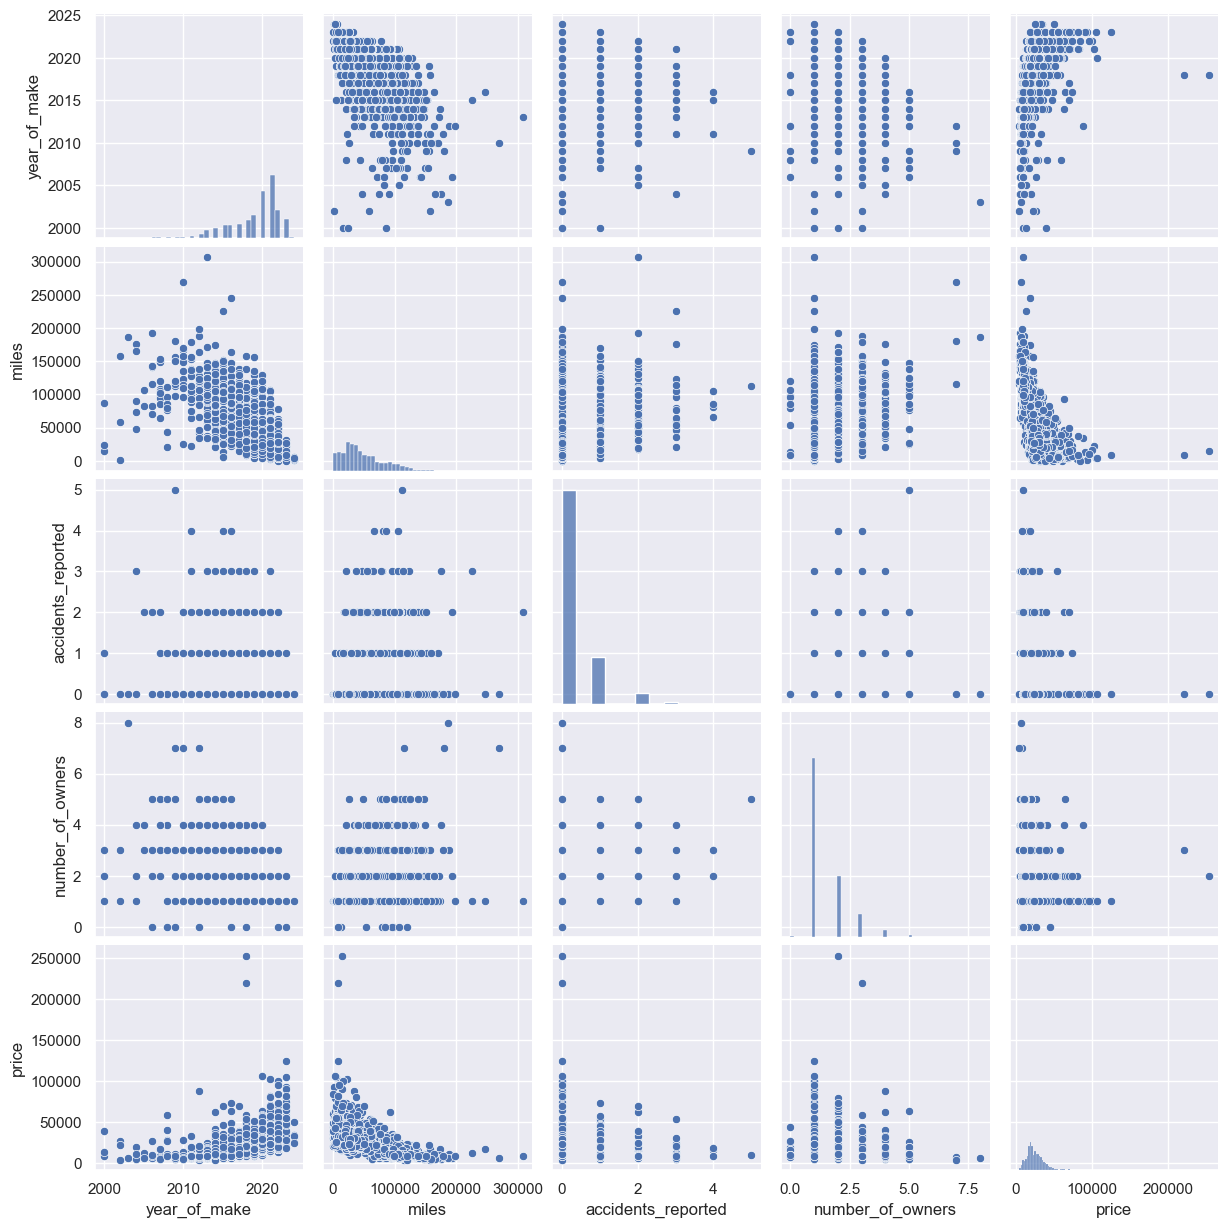

In [96]:
# Visualize data:
# Apply the default theme
sns.set_theme()

sns.pairplot(data=usedcars_data)

Initial observations from the graph above:

- The newer models (year of make) are more expensive than the older ones, except that there are some outliers.
- The higher the mileage the lesser the price, except that there are some outliers.
- As the number of accidents increase, the price of the vehicles reduces, except some outliers.

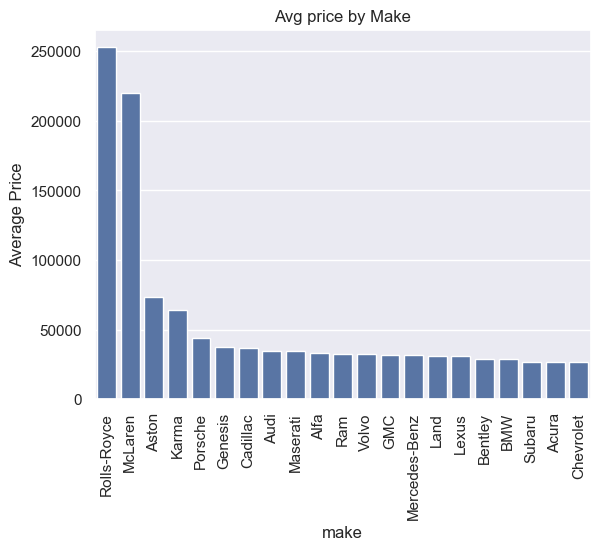

In [97]:
# Create a graph of car price vs car make: 
sns.barplot(
    x='make', y='price', 
    data=usedcars_data.groupby('make')['price'].mean().to_frame().sort_values(by='price', ascending=False).head(21).reset_index(),
)


plt.title("Avg price by Make");
plt.xticks(rotation=90);
plt.ylabel("Average Price");

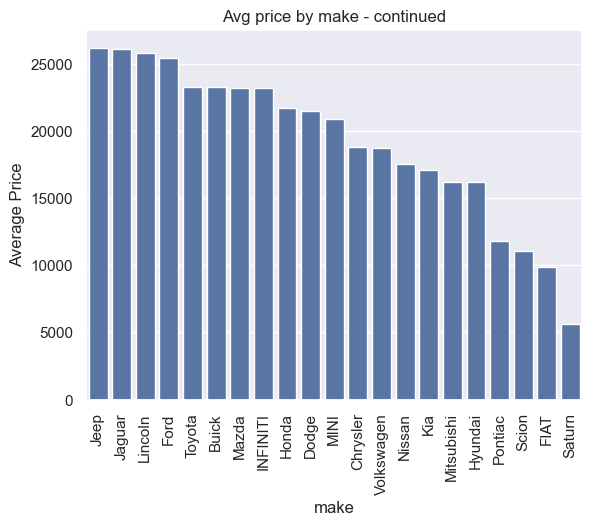

In [98]:
sns.barplot(
    x='make', y='price',
    data=usedcars_data.groupby('make')['price'].mean().to_frame().sort_values(by='price', ascending=False).tail(21).reset_index()
)
plt.title("Avg price by make - continued");
plt.xticks(rotation=90);
plt.ylabel("Average Price");

Following Make have much lower prices than others: 

Chevrolet, Mercedes-Benz, BMW, Porsche, Land, Volvo, Lexus, Acura, Maserati,
Subaru, Audi, GMC, Cadillac, Ram, Alfa, Aston, Genesis, Karma, Scion, Bentley, Saturn.

From the graphic representation above, we see that number of accidents, mileage and number of owners affect the price, but there are some outliers.

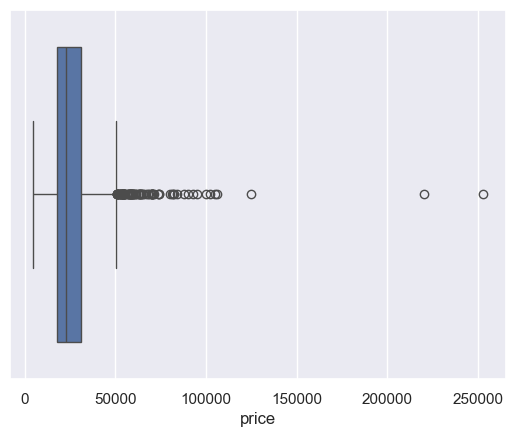

count      2312.000000
mean      25841.419983
std       13880.328572
min        4395.000000
25%       17991.000000
50%       22999.000000
75%       30999.250000
max      252900.000000
Name: price, dtype: float64


In [99]:
# Plot using the price as datapoints
box_plot = sns.boxplot(
    x=usedcars_data["price"].sort_values()
)

plt.show()

print(usedcars_data["price"].sort_values().describe())

Text(0.5, 1.0, 'Average car price by accidents reported')

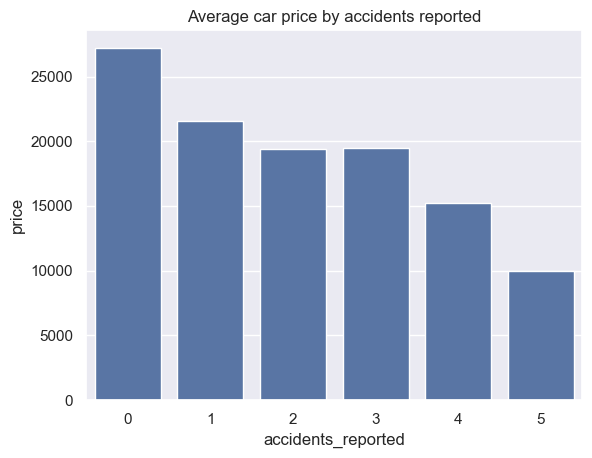

In [100]:
# Bar plot to show correlation between accidents reported and price of the car:
sns.barplot(
    x='accidents_reported', y='price',
    data=usedcars_data.groupby('accidents_reported')['price'].mean().to_frame().reset_index(),
)

plt.title("Average car price by accidents reported")

In [101]:
# define a function that calculates lower and upper bounds to identify outliers using the Inter Quartile Range (IQR)
def return_bounds(q1: float, q3: float):
    IQR = q3 - q1
    lower = q1 - (1.5 * IQR)
    upper = q3 + (1.5 * IQR)
    return lower, upper

# make a copy of the dataframe
outliers_df = usedcars_data.copy()

# use the method we defined previously to remove outliers
lower_bound, upper_bound = return_bounds(q1=17991, q3=30999.25)

# find the indexes of the rows that have price outliers
ind_q1 = outliers_df[(outliers_df['price'] < lower_bound)].index
ind_q3 = outliers_df[(outliers_df['price'] > upper_bound)].index

# remove them from our dataframe
outliers_df.drop(index=ind_q1, inplace=True)
outliers_df.drop(index=ind_q3, inplace=True)

outliers_df

,make,model,year_of_make,miles,exterior_color,interior_color,accidents_reported,number_of_owners,price
0,Kia,Forte,2022,41406,Gray,Black,0,1,15988
1,Chevrolet,Silverado 1500,2021,15138,White,Black,1,1,38008
2,Toyota,RAV4,2022,32879,Silver,Unknown,0,1,24988
3,Honda,Civic,2020,37190,Blue,Black,0,1,18998
4,Honda,Civic,2020,27496,Black,Black,0,1,19498
...,...,...,...,...,...,...,...,...,...
2307,Ford,Escape,2013,98601,Silver,Unknown,2,3,8995
2308,Mercedes-Benz,R-Class,2009,120694,Black,Black,1,3,9495
2309,Mercedes-Benz,GLC,2022,27894,Gray,Gray,0,2,29999
2310,Honda,CR-V,2021,50220,Gray,Unknown,0,1,22992


<AxesSubplot:xlabel='price'>

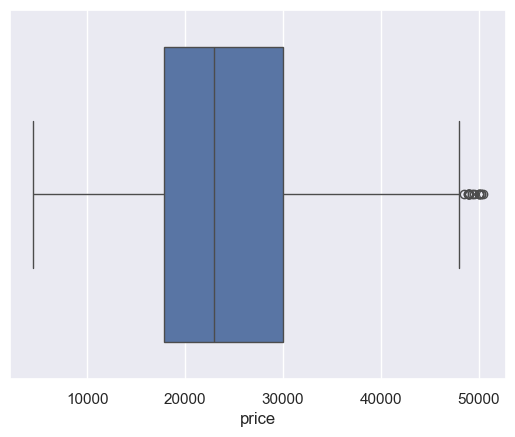

In [102]:
sns.boxplot(x=outliers_df['price'].sort_values())

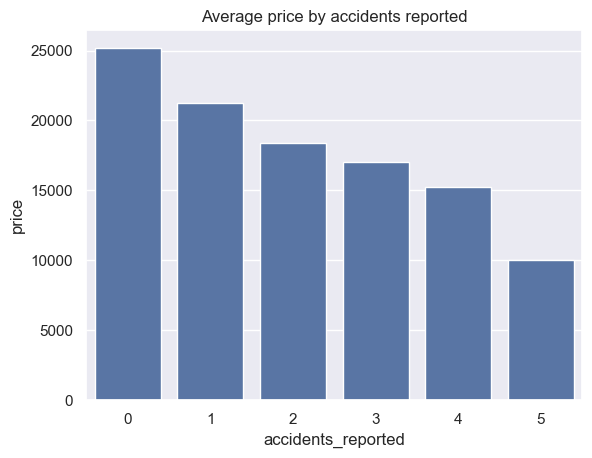

In [103]:
# Create bargraph again with outliers removed:
sns.barplot(
    x='accidents_reported', y='price', 
    data=outliers_df.groupby('accidents_reported')['price'].mean().to_frame().reset_index(),
)
plt.title("Average price by accidents reported");

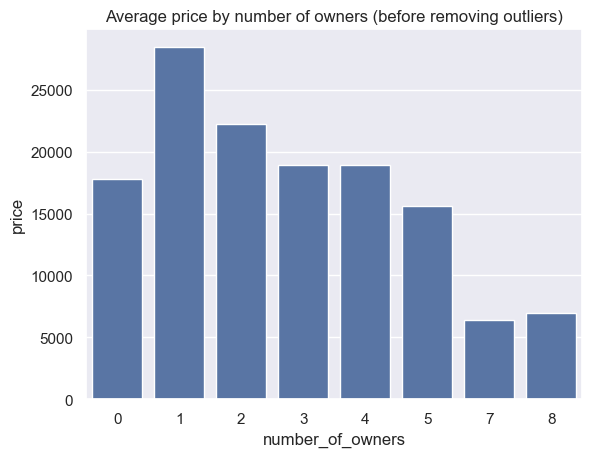

In [104]:
# Plot graph to show correlation between number of owners and price:
sns.barplot(
    x='number_of_owners', y='price', 
    data=usedcars_data.groupby('number_of_owners')['price'].mean().to_frame().reset_index()
)

# set the plot's title
plt.title("Average price by number of owners (before removing outliers)");

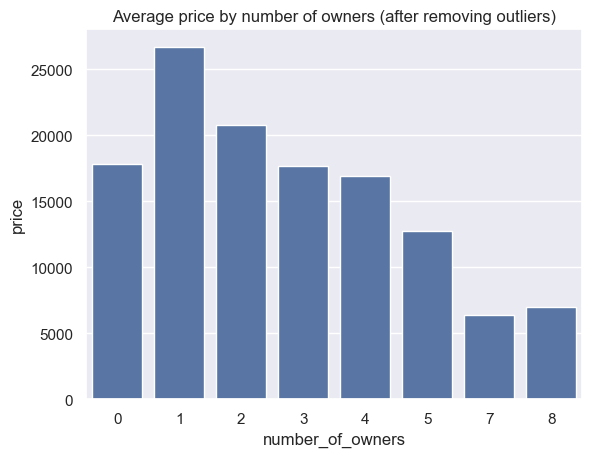

In [105]:
# Plot graph to show correlation between number of owners and price (after removing outliers):
sns.barplot(
    x='number_of_owners', y='price', 
    data=outliers_df.groupby('number_of_owners')['price'].mean().to_frame().reset_index()
)

# set the plot's title
plt.title("Average price by number of owners (after removing outliers)");

We see that the outliers had little to no effect on the number of previous owners. Also. some of these cars have 0 previous owners which means this dataset includes new cars and therefore this should be out of scope for the purpose of this analysis and model creation.

In [106]:
# Get count of new cars i.e., car with 0 previous owners:
print(usedcars_data['number_of_owners'].value_counts()[0])

10


In [107]:
# Remove rows with 0 previous owners:

new_cars_index = usedcars_data[(usedcars_data['number_of_owners'] == 0)].index
usedcars_data.drop(index=new_cars_index, inplace=True)


In [108]:
index_newcars = outliers_df[(outliers_df['number_of_owners'] == 0)].index
outliers_df.drop(index=index_newcars, inplace=True)

<AxesSubplot:xlabel='miles', ylabel='price'>

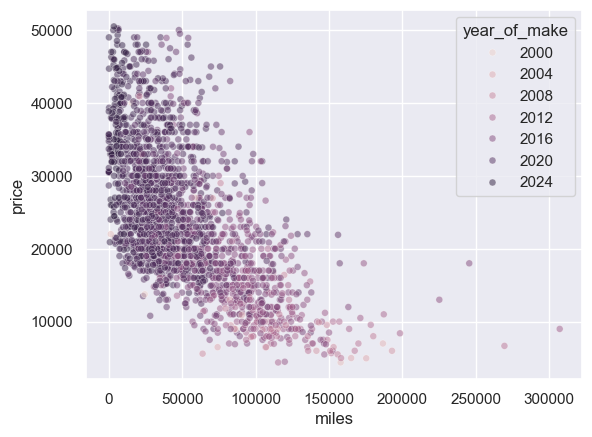

In [109]:
# Visualize mileage vs price:

sns.scatterplot(
    x='miles', y='price', 
    data=outliers_df, hue='year_of_make', s=25, alpha=0.5
)

From the graph above, we can see mileage contributes to determining the price however it is not the only factor determining the price. Other factors such as number of previous owners, accidents, make and model, year of make are also factors determining the price. It is a wholistic view of the car history that determines its price rather than a single factor.

We will see if we can build a model that can take all these factors into consideration and predict a car's fair price.

In [110]:
# Create a copy of our dataframe for the purpose of building a model:
usedcars_final_df = outliers_df.copy()

# features: make, model, year of make, miles, exterior color, interior color, accidents reported, and number of owners
X = usedcars_final_df.drop(columns=['price'])
# y variable: price
y = usedcars_final_df['price']

In [111]:
numval_columns = ['year_of_make', 'miles', 'accidents_reported', 'number_of_owners', 'price']

actual_data = usedcars_final_df[numval_columns].describe()

scaled_data = pd.DataFrame(StandardScaler().fit_transform(usedcars_final_df[numval_columns]), columns=numval_columns)

print(
    "Original Data:", 
    actual_data.describe(),
    sep="\n\n"
)
print()
print(
    "Scaled data using Standard Scaler:",
    scaled_data.describe(),
    sep="\n\n"
)

Original Data:

       year_of_make          miles  accidents_reported  number_of_owners  \
count      8.000000       8.000000            8.000000          8.000000   
mean    1789.780285   66764.503532          277.485960        278.671380   
std      725.120424  100038.446644          782.471704        781.994531   
min        3.432887      25.000000            0.000000          0.852074   
25%     2012.750000   19299.750000            0.000000          1.000000   
50%     2019.404697   38865.186327            0.144535          1.259485   
75%     2021.750000   55975.616701            1.698958          3.500000   
max     2214.000000  307292.000000         2214.000000       2214.000000   

              price  
count      8.000000  
mean   20187.086914  
std    15732.046978  
min     2214.000000  
25%     8147.753022  
50%    20420.625000  
75%    25618.080962  
max    50491.000000  

Scaled data using Standard Scaler:

       year_of_make         miles  accidents_reported  number_of

In [112]:
numval_columns = ['year_of_make', 'miles', 'accidents_reported', 'number_of_owners', 'price']

actual_data = usedcars_final_df[numval_columns].describe()

scaled_data = pd.DataFrame(QuantileTransformer().fit_transform(usedcars_final_df[numval_columns]), columns=numval_columns)

print(
    "Original Data:", 
    actual_data.describe(),
    sep="\n\n"
)
print()
print(
    "Scaled data using Quantile Transformer:",
    scaled_data.describe(),
    sep="\n\n"
)

Original Data:

       year_of_make          miles  accidents_reported  number_of_owners  \
count      8.000000       8.000000            8.000000          8.000000   
mean    1789.780285   66764.503532          277.485960        278.671380   
std      725.120424  100038.446644          782.471704        781.994531   
min        3.432887      25.000000            0.000000          0.852074   
25%     2012.750000   19299.750000            0.000000          1.000000   
50%     2019.404697   38865.186327            0.144535          1.259485   
75%     2021.750000   55975.616701            1.698958          3.500000   
max     2214.000000  307292.000000         2214.000000       2214.000000   

              price  
count      8.000000  
mean   20187.086914  
std    15732.046978  
min     2214.000000  
25%     8147.753022  
50%    20420.625000  
75%    25618.080962  
max    50491.000000  

Scaled data using Quantile Transformer:

       year_of_make        miles  accidents_reported  numbe

From the above we can see QuantileTransformer gives a better scaled data than StandardScaler as it removes negative values which is helpful.

In [113]:
# Initialize the SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imp.fit_transform(X)

array([['Kia', 'Forte', 2022, ..., 'Black', 0, 1],
       ['Chevrolet', 'Silverado 1500', 2021, ..., 'Black', 1, 1],
       ['Toyota', 'RAV4', 2022, ..., 'Unknown', 0, 1],
       ...,
       ['Mercedes-Benz', 'GLC', 2022, ..., 'Gray', 0, 2],
       ['Honda', 'CR-V', 2021, ..., 'Unknown', 0, 1],
       ['Honda', 'Civic', 2021, ..., 'Black', 0, 1]], dtype=object)

In [114]:
# Define pipeline for numerical values columns
numvalues_pipeline = Pipeline(steps=[
    ('impute_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale', QuantileTransformer())
])

# Define pipeline for categorical values columns
categorical_pipeline = Pipeline(steps=[
    ('impute_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Apply ColumnTransformer to scale and encode:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numvalues_pipeline, ['year_of_make', 'miles', 'accidents_reported', 'number_of_owners']),
        ('categoric', categorical_pipeline, ['make', 'model', 'exterior_color', 'interior_color']),
    ], remainder="passthrough"
)

In [115]:
# split the data into Train and Test datasets with the test_size being 20% of the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# import models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_log_error 
from sklearn.metrics import median_absolute_error, mean_gamma_deviance, mean_poisson_deviance
from sklearn.neighbors import KNeighborsRegressor

# Construct pipeline
RFR = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=5))
])

KNN = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsRegressor())
])

In [116]:
# Gridsearch:

forest_model = GridSearchCV(
    estimator=RFR,
    param_grid={
        'model__bootstrap': [True, False],
        'model__criterion': ['friedman_mse', 'squared_error', 'poisson'],
        'model__max_features': [3, 4, 5, 6, 7],
        'model__n_estimators': [int(x) for x in np.linspace(10, 80, 10)],
    },
    verbose=2,
    n_jobs=4,
    scoring={"r2_score": make_scorer(r2_score), "mean_gamma_deviance": make_scorer(mean_gamma_deviance)},
    refit="mean_gamma_deviance",
    cv=3
)

knn_model = GridSearchCV(
    estimator=KNN,
    param_grid={
        'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'model__weights': ['uniform', 'distance'],
    },
    verbose=2,
    n_jobs=4,
    scoring={"r2_score": make_scorer(r2_score), "mean_gamma_deviance": make_scorer(mean_gamma_deviance)},
    refit="r2_score",
    cv=3
)

In [117]:
# Train the model: RandomForestRegressor
forest_model.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          QuantileTransformer())]),
                                                                         ['year_of_make',
                                                                          'miles',
                                                                          'accidents_reported',
                                                                          'number_of_owners']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(st...
                                        RandomForestRegressor(random_state=5))]),
             n_jobs=4,
             param_grid={'model__bootstrap': [True, False],
                         'model__criterion': ['friedman_mse', 'squared_error',
                                              'poisson'],
                         'model__max_features': [3, 4, 5, 6, 7],
                         'model__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64,
                                                 72, 80]},
             refit='mean_gamma_deviance',
             scoring={'mean_gamma_deviance': make_scorer(mean_gamma_deviance),
                      'r2_score': make_scorer(r2_score)},
             verbose=2)

In [118]:
forest_model.best_params_

{'model__bootstrap': True,
 'model__criterion': 'squared_error',
 'model__max_features': 3,
 'model__n_estimators': 10}

In [119]:
forest_ypred = forest_model.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, forest_ypred, squared=False)

5271.400972139616

In [120]:
r2_score(y_test, forest_ypred)

0.6820098637015743

In [121]:
y_test.describe()

count      443.000000
mean     24363.911964
std       9358.579982
min       4966.000000
25%      17998.000000
50%      22998.000000
75%      29997.500000
max      48995.000000
Name: price, dtype: float64

In [122]:
# Fit the model: KNeighborsRegressor
knn_model.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          QuantileTransformer())]),
                                                                         ['year_of_make',
                                                                          'miles',
                                                                          'accidents_reported',
                                                                          'number_of_owners']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(st...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['make',
                                                                          'model',
                                                                          'exterior_color',
                                                                          'interior_color'])])),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=4,
             param_grid={'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__weights': ['uniform', 'distance']},
             refit='r2_score',
             scoring={'mean_gamma_deviance': make_scorer(mean_gamma_deviance),
                      'r2_score': make_scorer(r2_score)},
             verbose=2)

In [125]:
# Review Results - RandomForestRegressor

print("Train: ", forest_model.score(X_train, np.ravel(y_train)))
print("Test: ", forest_model.score(X_test, np.ravel(y_test)))

Train:  0.013168299134512137
Test:  0.057273044753855966


In [126]:
# Review Results - KNeigborsRegressor

print("Train", knn_model.score(X_train, np.ravel(y_train)))
print("Test", knn_model.score(X_test, np.ravel(y_test)))

Train 0.9999999999997643
Test 0.5726496787711182


Random Forest Model is returning better accuracy than the KNN Model. KNN model appears to be an overfit.

R2 Score for RandomForestRegressor model is about 0.68, which reflects a fair performing model. The mean squared error is about 5000. This is not a huge value as the minimum car value in this dataset is about 5000 and maximum value is about 50000, given that a variation of about 5000 from a bigger picture perspective is not a big difference. So we can conclude RandomForestRegressor is a good model to predict used car prices. The result of this model performance are presented below in a dataframe and scatter plots.

In [127]:
pd.DataFrame(forest_model.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__criterion,param_model__max_features,param_model__n_estimators,params,split0_test_r2_score,...,split2_test_r2_score,mean_test_r2_score,std_test_r2_score,rank_test_r2_score,split0_test_mean_gamma_deviance,split1_test_mean_gamma_deviance,split2_test_mean_gamma_deviance,mean_test_mean_gamma_deviance,std_test_mean_gamma_deviance,rank_test_mean_gamma_deviance
0,0.135087,0.002061,0.015661,0.001247,True,friedman_mse,3,10,"{'model__bootstrap': True, 'model__criterion':...",0.638602,...,0.616754,0.627810,0.008921,298,0.059624,0.071032,0.069993,0.066883,0.005151,2
1,0.205935,0.008302,0.016667,0.000939,True,friedman_mse,3,17,"{'model__bootstrap': True, 'model__criterion':...",0.661000,...,0.642065,0.647943,0.009248,295,0.057369,0.068754,0.065159,0.063761,0.004752,6
2,0.279854,0.009662,0.016331,0.002059,True,friedman_mse,3,25,"{'model__bootstrap': True, 'model__criterion':...",0.674647,...,0.651936,0.659998,0.010376,283,0.054438,0.066704,0.064388,0.061843,0.005321,11
3,0.380289,0.009248,0.020077,0.002917,True,friedman_mse,3,33,"{'model__bootstrap': True, 'model__criterion':...",0.682883,...,0.659380,0.665801,0.012202,276,0.053414,0.065802,0.062864,0.060693,0.005285,20
4,0.456906,0.010886,0.021090,0.000709,True,friedman_mse,3,41,"{'model__bootstrap': True, 'model__criterion':...",0.685015,...,0.667971,0.671749,0.009666,262,0.052871,0.064652,0.060909,0.059478,0.004915,28


In [128]:
pd.DataFrame(knn_model.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,split0_test_r2_score,split1_test_r2_score,split2_test_r2_score,mean_test_r2_score,std_test_r2_score,rank_test_r2_score,split0_test_mean_gamma_deviance,split1_test_mean_gamma_deviance,split2_test_mean_gamma_deviance,mean_test_mean_gamma_deviance,std_test_mean_gamma_deviance,rank_test_mean_gamma_deviance
0,0.033406,0.001415,0.034699,0.001247,1,uniform,"{'model__n_neighbors': 1, 'model__weights': 'u...",0.208217,0.270543,0.296295,0.258351,0.036977,19,0.152077,0.138189,0.127474,0.139246,0.010072,1
1,0.033930,0.001521,0.030241,0.003728,1,distance,"{'model__n_neighbors': 1, 'model__weights': 'd...",0.208217,0.270543,0.296295,0.258351,0.036977,19,0.152077,0.138189,0.127474,0.139246,0.010072,1
2,0.034139,0.001467,0.040182,0.014855,2,uniform,"{'model__n_neighbors': 2, 'model__weights': 'u...",0.409390,0.435128,0.471375,0.438631,0.025426,18,0.104236,0.099944,0.100796,0.101659,0.001855,4
3,0.041664,0.008384,0.035083,0.004549,2,distance,"{'model__n_neighbors': 2, 'model__weights': 'd...",0.410050,0.440703,0.470110,0.440288,0.024521,17,0.105520,0.099367,0.100524,0.101804,0.002670,3
4,0.042671,0.003483,0.032960,0.002533,3,uniform,"{'model__n_neighbors': 3, 'model__weights': 'u...",0.475953,0.498601,0.488608,0.487721,0.009267,16,0.090754,0.089482,0.095901,0.092046,0.002775,5


Text(0, 0.5, 'actual')

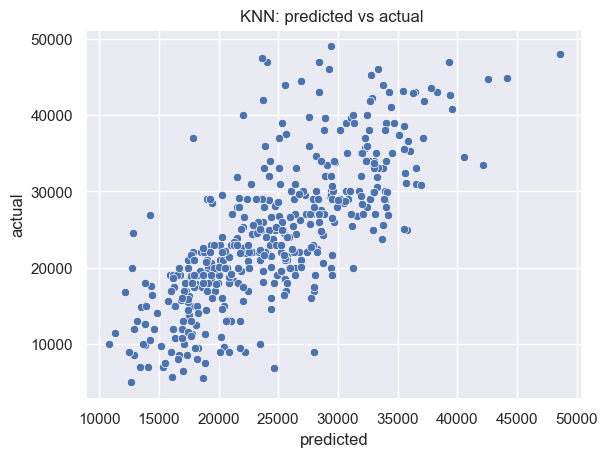

In [129]:
sns.scatterplot(x=knn_model.predict(X_test), y=np.ravel(y_test))
plt.title("KNN: predicted vs actual ")
plt.xlabel("predicted")
plt.ylabel("actual")

Text(0, 0.5, 'actual')

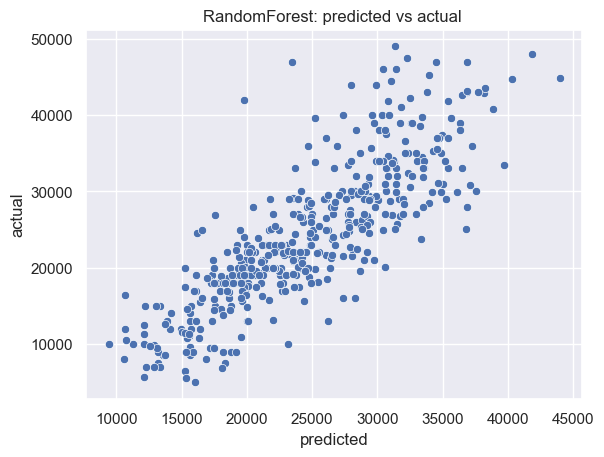

In [130]:
sns.scatterplot(x=forest_model.predict(X_test), y=np.ravel(y_test))
plt.title("RandomForest: predicted vs actual ")
plt.xlabel("predicted")
plt.ylabel("actual")

Sample Predictions:

In [131]:
# Actual price of the car below is around $19K based on information seen online
civi = pd.DataFrame(
    {   "make": "Honda",
        "model": "Civic",
        "year_of_make": 2021,
        "miles": 19124,
        "exterior_color": "Gray",
        "interior_color": "Black",
        "accidents_reported": 1,
        "number_of_owners": 1
    }, 
    index=[0]
)

# Actual price of the car below is around $23K based on information seen online
rogu = pd.DataFrame(
    {   "make": "Nissan",
        "model": "Rogue",
        "year_of_make": 2021,
        "miles": 24546,
        "exterior_color": "White",
        "interior_color": "Gray",
        "accidents_reported": 0,
        "number_of_owners": 1
    }, 
    index=[0]
)

# # Actual price of the car below is around $16K based on information seen online
fesc = pd.DataFrame(
    {   "make": "Ford",
        "model": "Escape",
        "year_of_make": 2017,
        "miles": 81015,
        "exterior_color": "Gray",
        "interior_color": "Black",
        "accidents_reported": 0,
        "number_of_owners": 1
    }, 
    index=[0]
)

print(f"KNearestNeighbors: Resale price is: ${round(knn_model.predict(X=civi)[0], 2)}")
print(f"RandomForestRegressor: Resale price is: ${round(forest_model.predict(X=civi)[0], 2)}")

print(f"KNearestNeighbors: Resale price is: ${round(knn_model.predict(X=rogu)[0], 2)}")
print(f"RandomForestRegressor: Resale price is: ${round(forest_model.predict(X=rogu)[0], 2)}")

print(f"KNearestNeighbors: Resale price is: ${round(knn_model.predict(X=fesc)[0], 2)}")
print(f"RandomForestRegressor: Resale price is: ${round(forest_model.predict(X=fesc)[0], 2)}")

KNearestNeighbors: Resale price is: $19041.55
RandomForestRegressor: Resale price is: $21725.3
KNearestNeighbors: Resale price is: $20459.79
RandomForestRegressor: Resale price is: $21794.4
KNearestNeighbors: Resale price is: $23233.1
RandomForestRegressor: Resale price is: $16630.9


From the sample predictions above, we see that Random Forest Regressor Model returns results close to the actuals, though KNN Model also returns results more or less closer to the actuals. Random Forest Regressor Model is slightly more accurate than KNeigbors Model.

In [132]:
# Deep Learning Model:

# Convert categorical data to numeric with `pd.get_dummies`
numapp_df = pd.get_dummies(usedcars_final_df)
numapp_df

# features: make, model, year of make, miles, exterior color, interior color, accidents reported, and number of owners
X = numapp_df.drop(columns=['price'])
# y variable: price
y = numapp_df['price']

# split the data into Train and Test datasets with the test_size being 20% of the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instances
scaler = QuantileTransformer()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [139]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input_features = len(X_train_scaled[0])
hid_nodes_layer1 = 80
hid_nodes_layer2 = 50
hid_nodes_layer3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hid_nodes_layer1, input_dim=num_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hid_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hid_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 80)                28880     
                                                                 
 dense_8 (Dense)             (None, 50)                4050      
                                                                 
 dense_9 (Dense)             (None, 30)                1530      
                                                                 
 dense_10 (Dense)            (None, 1)                 31        
                                                                 
Total params: 34491 (134.73 KB)
Trainable params: 34491 (134.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
from tensorflow.keras.metrics import RootMeanSquaredError
rsme = RootMeanSquaredError()
# Compile the model
nn.compile(loss="mse", optimizer="adam", metrics=["mae",rsme])

In [141]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
52/52 [==============================] - 1s 3ms/step - loss: 685097152.0000 - mae: 24394.7812 - root_mean_squared_error: 26174.3613
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 680892800.0000 - mae: 24306.4648 - root_mean_squared_error: 26093.9219
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 641832960.0000 - mae: 23472.7969 - root_mean_squared_error: 25334.4219
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 497214720.0000 - mae: 20052.8652 - root_mean_squared_error: 22298.3125
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 257172608.0000 - mae: 13106.6963 - root_mean_squared_error: 16036.6025
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 121073552.0000 - mae: 8623.0479 - root_mean_squared_error: 11003.3428
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 98222560.0000 - mae: 7888.1514 - root_mean_squared_error: 9910.7

In [142]:
# Evaluate the model using the test data
model_loss, model_mae, model_rmse = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Mean Absolute Error: {model_mae}, Root Mean Squared Error: {model_rmse}")

18/18 - 0s - loss: 20183912.0000 - mae: 3040.5459 - root_mean_squared_error: 4492.6509 - 195ms/epoch - 11ms/step
Loss: 20183912.0, Mean Absolute Error: 3040.5458984375, Root Mean Squared Error: 4492.65087890625


For the above deep learning model, the root mean squared error is about 4500, which reflects a fair performing model. The root mean squared error is not a huge value as the minimum car value in this dataset is about 5000 and maximum value is about 50000, so a variation of about 5000 from a overall perspective is not a big difference. Therefore, we can conclude this is a good model to predict used car prices. The result of this model performance are presented below in a dataframe and scatter plots.

In [143]:
fit_model.history.keys()

dict_keys(['loss', 'mae', 'root_mean_squared_error'])

<AxesSubplot:>

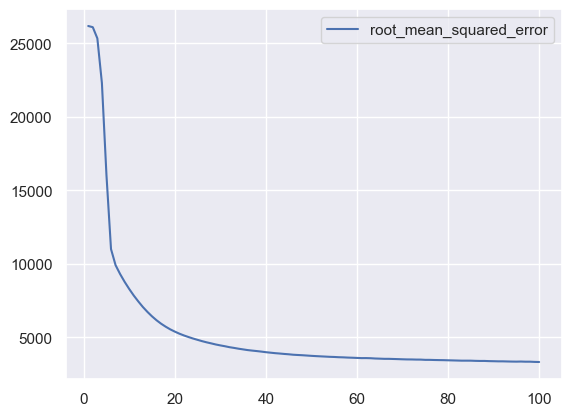

In [144]:
# plotting the root mean squared error
rmse_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['root_mean_squared_error'])+1))
rmse_df.plot(y = 'root_mean_squared_error')

In [145]:
# Export our model to HDF5 file

nn.save('Models/UsedCarsPricePredict.h5')